# Laboratorium 4 (Przepływ optyczny)

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

def plot(I):
    plt.figure(figsize=(36, 12))
    plt.imshow(I, cmap='gray')
    plt.axis('off')


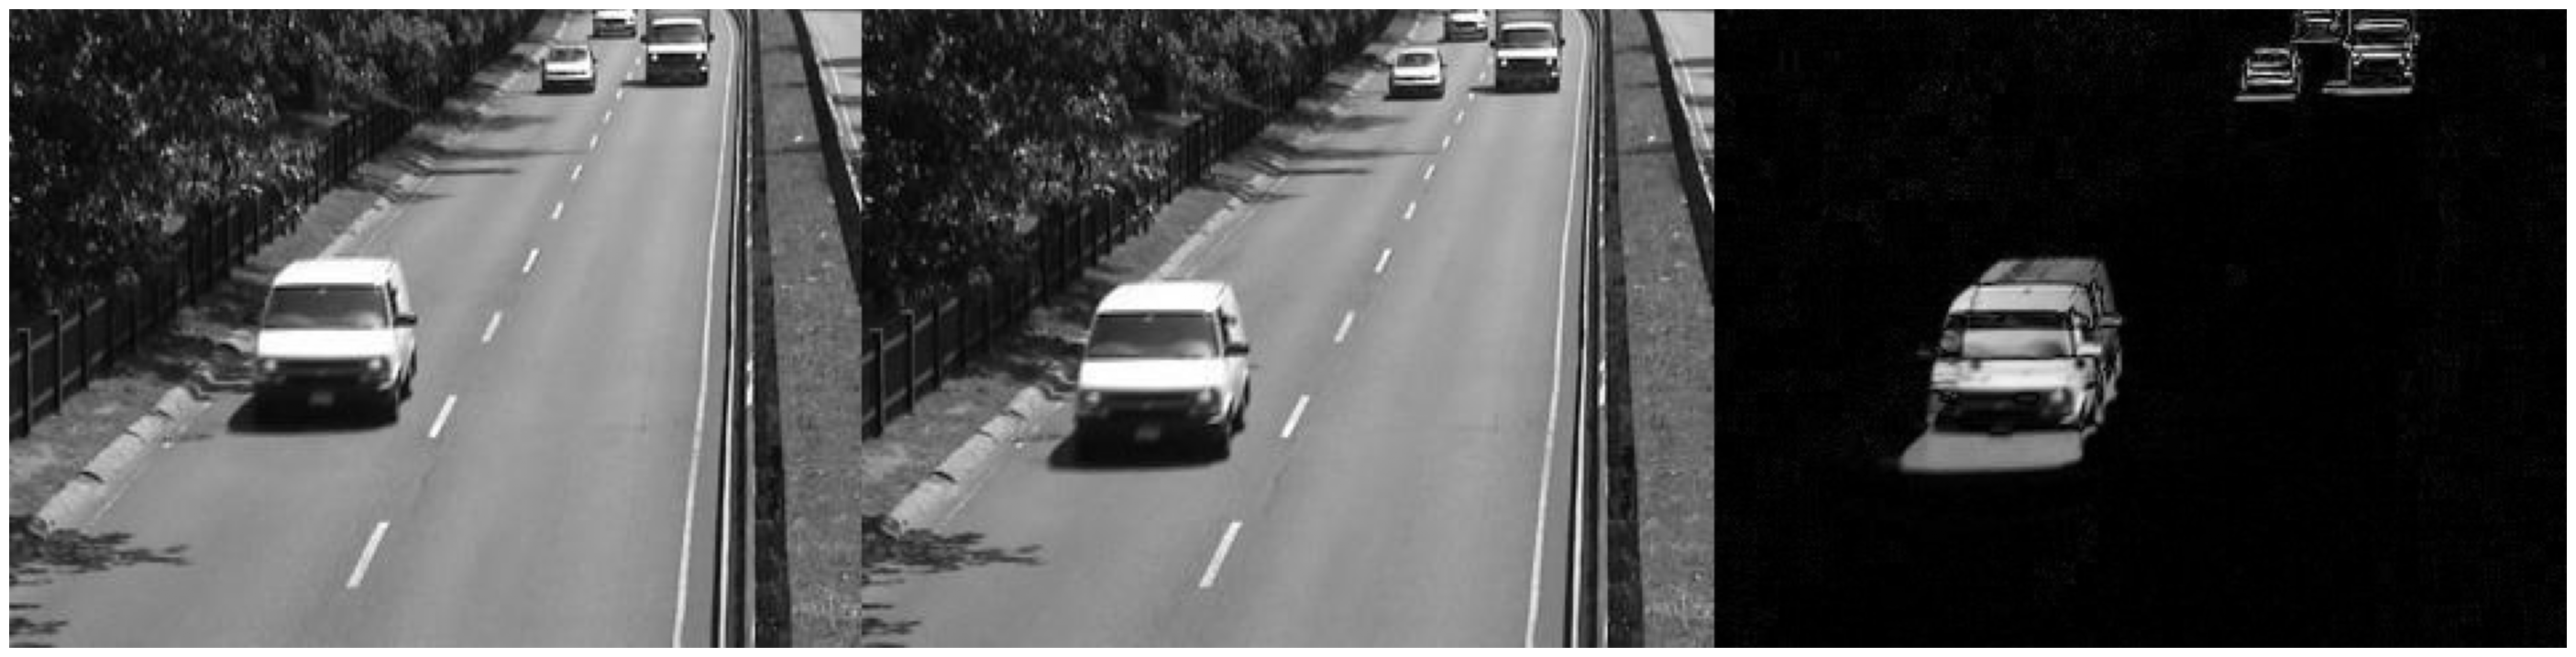

In [57]:
from tqdm.auto import tqdm

cm_gt = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/Materiały-20250325/cm_gt.png', cv2.IMREAD_GRAYSCALE)
cm1 = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/Materiały-20250325/cm1.png', cv2.IMREAD_GRAYSCALE)
cm2 = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/Materiały-20250325/cm2.png', cv2.IMREAD_GRAYSCALE)
I = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/Materiały-20250325/I.jpg', cv2.IMREAD_GRAYSCALE)
J = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/Materiały-20250325/J.jpg', cv2.IMREAD_GRAYSCALE)

compose = cv2.hconcat([I, J, cv2.absdiff(I, J)])

plot(compose)

### Zadanie 1 Metoda Blokowa

100%|██████████| 230/230 [00:35<00:00,  6.45it/s]


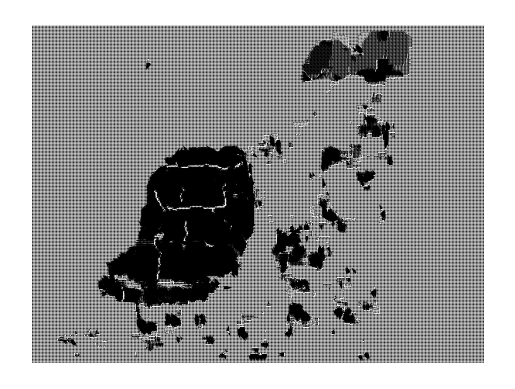

In [58]:
W2 = 5 # Wielkośc okna po jakim sie poruszamy
dX = dY = 5 # Zakres przesuniecia jakie przeszukujemy 

XX, YY = I.shape

u = np.zeros((XX, YY), dtype=np.float32)
v = np.zeros((XX, YY), dtype=np.float32)

for j in tqdm(range(W2, XX - W2)):  
    for i in range(W2, YY - W2):
        IO = np.float32(I[j - W2:j + W2 + 1, i - W2:i + W2 + 1]) # Wycinkek obrazu 

        min_dist = float('inf') 
        best_dx, best_dy = 0, 0

        for dy in range(j - dY, j + dY + 1):
            for dx in range(i - dX, i + dX + 1):
                if W2 <= dy < XX - W2 and W2 <= dx < YY - W2:
                    JO = np.float32(J[dy - W2:dy + W2 + 1, dx - W2:dx + W2 + 1]) 
                    dist = np.linalg.norm(JO - IO) 

                    if dist < min_dist:
                        min_dist = dist
                        best_dx, best_dy = dx, dy

        u[j, i] = best_dx - i
        v[j, i] = best_dy - j

# Normalizacja wektorów przepływu
#u /= np.max(np.abs(u) + 1e-6)2 
#v /= np.max(np.abs(v) + 1e-6)

plt.quiver(u, v)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

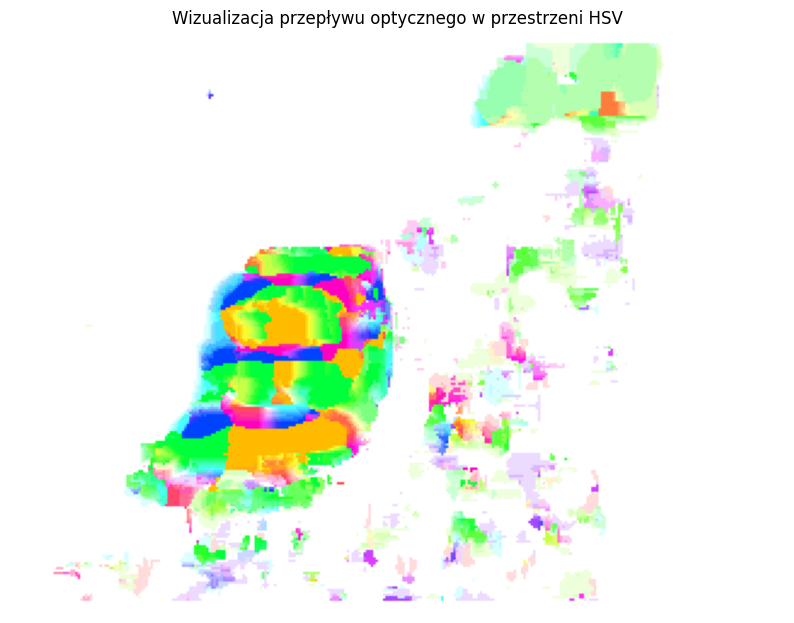

In [5]:
import cv2


magnitude, angle = cv2.cartToPolar(u, v)

H = (angle * 90 / np.pi).astype(np.uint8)  
S = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) 
V = np.full_like(S, 255)  

HSV = cv2.merge([H, S, V])
RGB = cv2.cvtColor(HSV, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(RGB)
plt.axis('off')
plt.title("Wizualizacja przepływu optycznego w przestrzeni HSV")
plt.show()

### Zadanie 2. Skalowanie obrazu

In [61]:
def of(I, J, W2=3, dY=3, dX=3):
    """
    Opis:
        Funckja oblicza przepływ optyczny 
    @param
        I - pierwszy obraz (referncyjny)
        J - drugi obraz (przesuniecie)
        W2 - Wielkośc połowy kernela
        dY - Max przesuniecie w osi Y
        dX - Max przesuanicie w osi X
    @return
        u - przesunie w osi X
        v - przesuneicie w osi Y
    """
    XX, YY = I.shape
    u = np.zeros((XX, YY), dtype=np.float32)
    v = np.zeros((XX, YY), dtype=np.float32)
    
    for j in tqdm(range(W2, XX - W2)):
        for i in range(W2, YY - W2):
            IO = np.float32(I[j - W2:j + W2 + 1, i - W2:i + W2 + 1])
            min_dist = float('inf')
            best_dx, best_dy = 0, 0
            
            for dy in range(j - dY, j + dY + 1):
                for dx in range(i - dX, i + dX + 1):
                    if W2 <= dy < XX - W2 and W2 <= dx < YY - W2:
                        JO = np.float32(J[dy - W2:dy + W2 + 1, dx - W2:dx + W2 + 1])
                        dist = np.linalg.norm(JO - IO)
                        
                        if dist < min_dist:
                            min_dist = dist
                            best_dx, best_dy = dx, dy
            
            u[j, i] = best_dx - i
            v[j, i] = best_dy - j
    
    return u, v

def vis_flow(u, v, YX, name):
    """
    Opis:
        Wizualizuje przypływ optyczny w formacie HSV
    @param:
        u - przesuneicie w osi X
        v - przesuneicie w osi Y
        YX - rozmiar obrazu 
        name - nazwa 
    @return:
        void
    """
    hsv = np.zeros((*YX, 3), dtype=np.uint8)
    mag, ang = cv2.cartToPolar(u, v)
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = 255
    hsv[..., 1] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    plt.imshow(flow_rgb)
    plt.axis('off')
    plt.show()

def pyramid(im, max_scale):
    """
    Opis:
        Tworzy piramide obrazu (zminiejszanie rodzielczośći)
    @param:
        im - obraz wejsciowy
        max_scale - liczba poziomów piramidy
    @return
        Lista pomniejsyzch obrazów [im, im/2, im/4 ...]
    """
    images = [im]
    for k in range(1, max_scale):
        images.append(cv2.resize(images[k - 1], (0, 0), fx=0.5, fy=0.5))
    return images

def multi_scale_of(I, J, max_scale=3, W2=3, dY=3, dX=3):
    IP = pyramid(I, max_scale) # Tworzenie listy obrazu referencyjnego
    JP = pyramid(J, max_scale) # Tworzneie listy obrazów przesuniecia
    
    I_new = IP[-1]
    u_total = np.zeros_like(I, dtype=np.float32)
    v_total = np.zeros_like(I, dtype=np.float32)
    
    for k in range(max_scale - 1, -1, -1):
        u, v = of(I_new, JP[k], W2, dY, dX)

        if k > 0:
            # Przeusniecie o u
            #rows, cols = I_new.shape
            #map_x, map_y = np.meshgrid(np.arange(cols), np.arange(rows), indexing='xy') # Tworzenie siatki wpolrzednych map_x siakta wsporzednych x, map_y wpolerdznie dla y

            # Dodanie przesunięcia
            #map_x = np.clip(map_x + u, 0, cols - 1).astype(np.float32) # przesunei wsporzendych wraz z ograniczeniem dla x
            #map_y = np.clip(map_y + v, 0, rows - 1).astype(np.float32) # przesunei wsporzendych wraz z ograniczeniem dla y

            # Przesunięcie obrazu za pomocą cv2.remap
            #I_new_new = cv2.remap(I_new, map_x, map_y, interpolation=cv2.INTER_LINEAR)  # przmapownaie pikseli na nowe wprzedne 

            #I_new = cv2.resize(I_new_new, (IP[k - 1].shape[1], IP[k - 1].shape[0]))

            rows, cols = I_new.shape
            I_new_new = np.zeros_like(I_new)  
            
            for i in range(rows):
                for j in range(cols):
                    new_i = int(np.clip(i + v[i, j], 0, rows - 1)) 
                    new_j = int(np.clip(j + u[i, j], 0, cols - 1))  

                    #new_i = int(i - v[i, j]) 
                    #new_j = int(j - u[i, j])  
                    
                    I_new_new[new_i, new_j] = I_new[i, j]  
                    
            I_new = cv2.resize(I_new_new, (IP[k - 1].shape[1], IP[k - 1].shape[0]))



        u *= 2 ** (k)
        v *= 2 ** (k)

        u_total += cv2.resize(u, (I.shape[1], I.shape[0]))
        v_total += cv2.resize(v, (I.shape[1], I.shape[0]))

        vis_flow(u, v, u.shape, "Optical Flow")
    


    return u_total, v_total

100%|██████████| 110/110 [00:08<00:00, 12.82it/s]


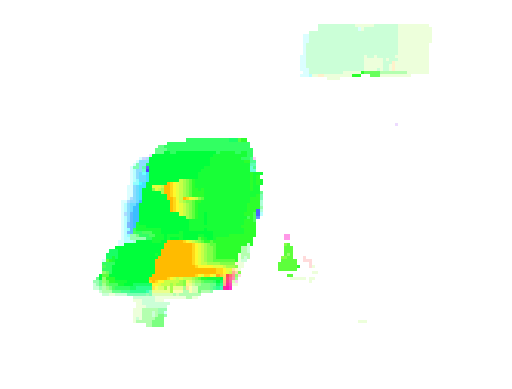

100%|██████████| 230/230 [00:37<00:00,  6.17it/s]


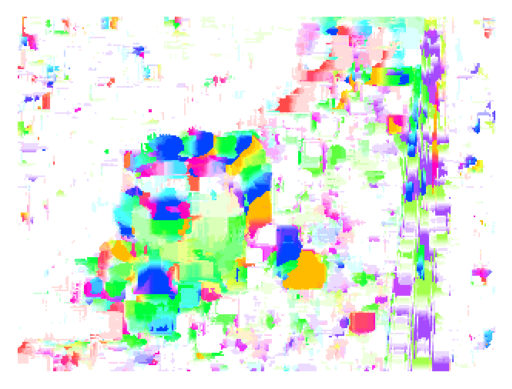

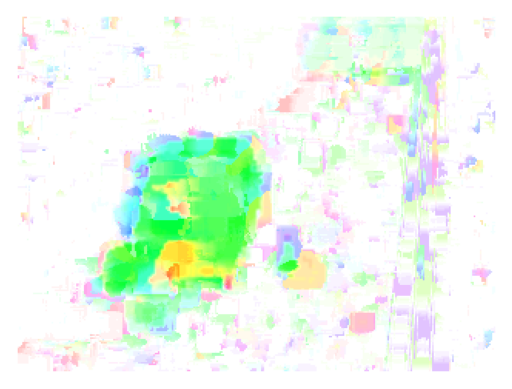

In [62]:
u, v = multi_scale_of(I, J, max_scale=2, W2=5, dY=5, dX=5)

vis_flow(u, v, I.shape, "Optical Flow")

100%|██████████| 50/50 [00:01<00:00, 32.95it/s]


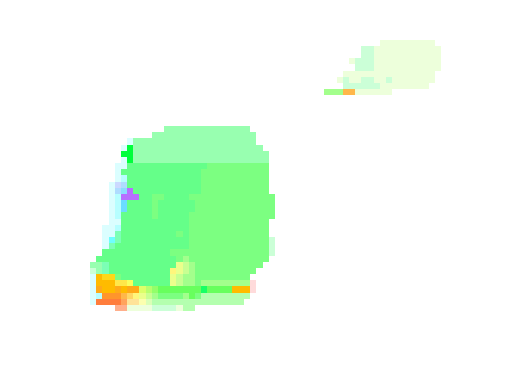

100%|██████████| 110/110 [00:07<00:00, 14.30it/s]


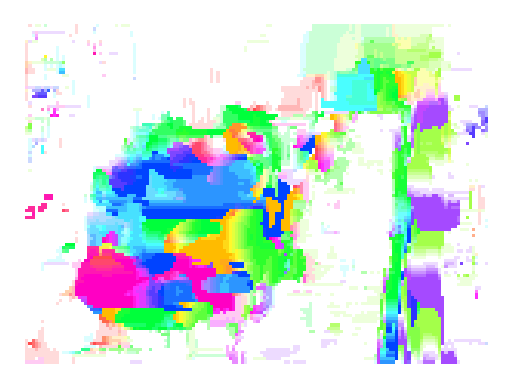

100%|██████████| 230/230 [00:33<00:00,  6.96it/s]


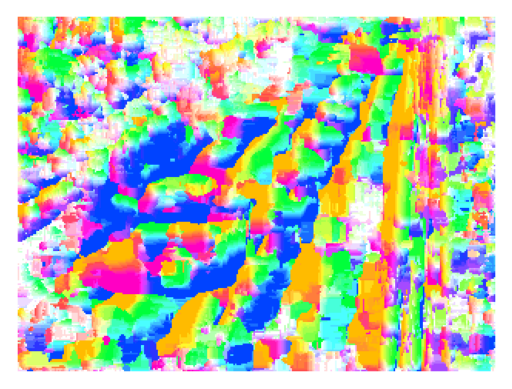

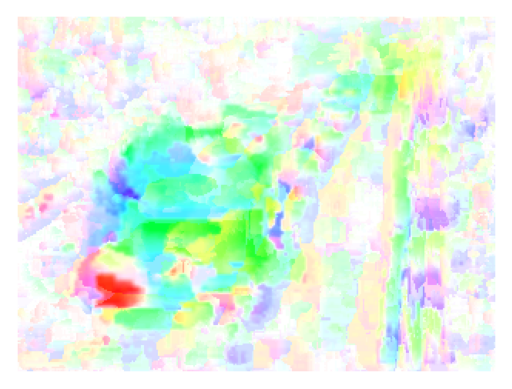

In [49]:
u, v = multi_scale_of(I, J, max_scale=3, W2=5, dY=5, dX=5)

vis_flow(u, v, I.shape, "Optical Flow")

100%|██████████| 42/42 [00:03<00:00, 12.94it/s]


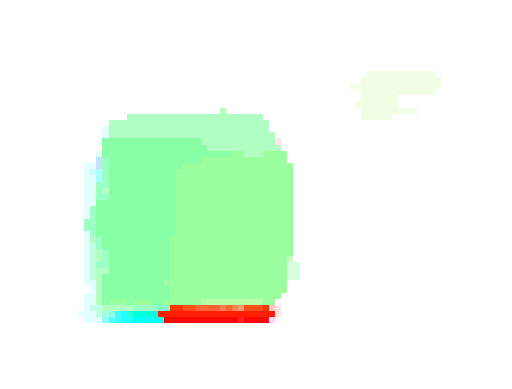

100%|██████████| 102/102 [00:21<00:00,  4.74it/s]


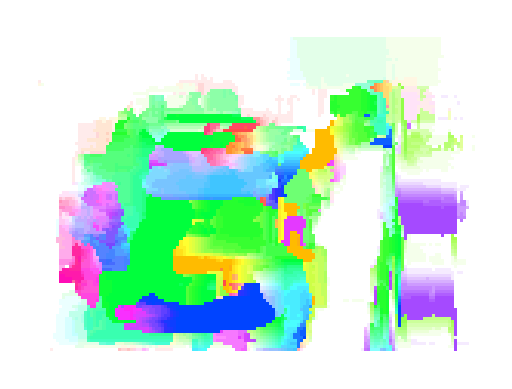

100%|██████████| 222/222 [01:41<00:00,  2.19it/s]


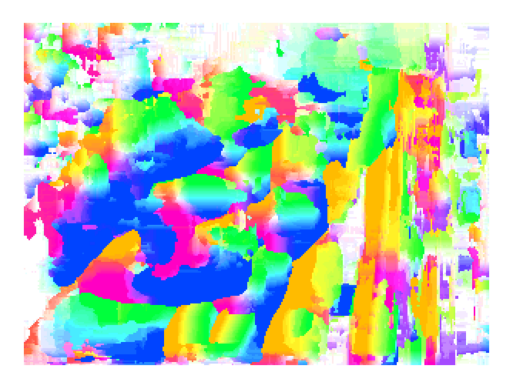

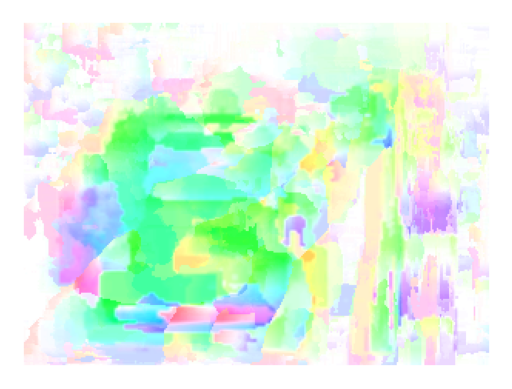

In [50]:
u, v = multi_scale_of(I, J, max_scale=3, W2=9, dY=9, dX=9)

vis_flow(u, v, I.shape, "Optical Flow")

### Zadanie dodatkowe 1 – Inne sposoby wyznaczania przepływu optycznego

In [3]:
input_folder = "/home/plorenc/Desktop/AiR_ISS/AVS/pedestrian/input/"

first_image_path = os.path.join(input_folder, "in000300.jpg")
prev_gray = cv2.imread(first_image_path, cv2.IMREAD_GRAYSCALE)

hsv_mask = np.zeros((prev_gray.shape[0], prev_gray.shape[1], 3), dtype=np.uint8)
hsv_mask[..., 2] = 255  

# Parametry do filtrowania
min_vector_magnitude = 2.0  # Minimalna długość wektora do narysowania

for i in range(301, 800):
    I_path = os.path.join(input_folder, f"in{i:06d}.jpg")
    gray = cv2.imread(I_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(I_path)  # Obraz kolorowy do rysowania

    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 
                                        0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv_mask[..., 0] = ang * 180 / np.pi / 2  
    hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  

    flow_rgb = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)
    
    # Rysowanie wektorów przepływu optycznego
    step = 10  # Co ile pikseli rysować wektor
    y, x = flow.shape[:2]
    for jj in range(0, y, step):
        for ii in range(0, x, step):
            fx, fy = flow[jj, ii]
            if np.sqrt(fx**2 + fy**2) > min_vector_magnitude:
                start_point = (ii, jj)
                end_point = (int(ii + fx), int(jj + fy))
                cv2.line(img, start_point, end_point, (0, 0, 255), 1)
                cv2.circle(img, end_point, 1, (255, 0, 0), -1) 

    cv2.imshow("Optical Flow Farneback", img)
    cv2.waitKey(10)
    
    prev_gray = gray.copy()

cv2.destroyAllWindows()

### Zadanie dodatkowe 2

In [5]:
history = 300
varTharshold = 20

prew_img = cv2.imread(os.path.join(input_folder, "in000300.jpg"), cv2.IMREAD_GRAYSCALE)

mog = cv2.createBackgroundSubtractorMOG2(history=history, varThreshold=varTharshold, detectShadows=False)

# Inicjalizacja słownika do przechowywania ID obiektów
object_ids = {}

for i in range(300, 900):
    I_path = os.path.join(input_folder, f"in{i:06d}.jpg")
    gray = cv2.imread(I_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(I_path)  # Obraz kolorowy do rysowania

    mask = mog.apply(img, learningRate=0.01)

    mask = cv2.medianBlur(mask, ksize=3)
    mask = cv2.erode(mask, kernel=(5, 5))

    # Obliczanie przepływu optycznego
    flow = cv2.calcOpticalFlowFarneback(prew_img, mask, None, 
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    prew_img = mask.copy()

    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    std = [np.std(magnitude, axis=1), np.std(angle, axis=1)]
    mean = [np.mean(magnitude, axis=1), np.mean(angle, axis=1)]
    flow_img = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    flow_img = np.uint8(flow_img)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(flow_img, connectivity=8)

    # Wykrywanie i indeksowanie obiektów
    img_with_objects = img.copy()  # Kopia do wykrytych obiektów
    if stats.shape[0] > 1:
        # Wybieramy komponent o największym obszarze
        tab = stats[1:, 4]  # Kolumna 4 zawiera obszar
        pi = np.argmax(tab) + 1  # Indeks największego komponentu (dodajemy 1, aby uwzględnić tło)

        # Rysowanie prostokąta wokół największego obiektu
        x, y, w, h, area = stats[pi]
        cv2.rectangle(img_with_objects, (x, y), (x + w, y + h), (155, 0, 0), 2)

        # Indeksacja obiektów
        object_id = None
        for key, value in object_ids.items():
            if abs(value[0] - x) < 50 and abs(value[1] - y) < 50:
                object_id = key
                break

        if object_id is None:
            object_id = len(object_ids) + 1

        # Zaktualizowanie pozycji obiektu w słowniku
        object_ids[object_id] = (x, y)

        # Dodanie tekstu z unikalnym ID obiektu
        cv2.putText(img_with_objects, f"ID: {object_id}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))
        # Dodanie tekstu z numerem obiektu
        cx, cy = centroids[pi]
        cv2.putText(img_with_objects, f"{pi}", (int(cx), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))

    # Segmentacja obiektów
    segmented_img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Przygotowanie obrazu z przepływem optycznym
    flow_visualization = np.zeros_like(img)
    hsv = np.zeros_like(img)
    hsv[..., 1] = 255
    hsv[..., 0] = angle * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    flow_visualization = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Łączenie obrazów w jeden
    top_row = cv2.hconcat([flow_visualization, segmented_img])
    bottom_row = cv2.hconcat([img_with_objects, img])  # Obraz z obiektami i oryginalny obraz
    final_image = cv2.vconcat([top_row, bottom_row])

    # Wyświetlenie obrazu
    cv2.imshow("Output", final_image)
    cv2.waitKey(10)

cv2.destroyAllWindows()